# Genome Shots

Browser shots.

**Inputs**: 
1. Config:
    - For each cluster, colour, description, new cluster number (set to same as original if it should not be changed)
2. Bigwig files per cluster
3. Seurat RNA file
4. ATAC->RNA cluster transfer tsv (should be same cluster IDs as old IDs)

In [1]:
library(ggplot2)
library(Gviz)
library(GenomicRanges)
library(patchwork)
library(ggplotify)
library(rtracklayer)
library(Seurat)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min



Attaching package: ‘S4Vectors’


The

In [2]:
DAYS = c("D0", "D2", "D4", "D6", "D8", "D10", "D12", "D14", "iPSC")

## Loading Inputs

### Day and Cluster Configs

In [3]:
day_config = read.table("./configs/day.tsv", comment.char = '', header=T)
day_config$colour = as.character(day_config$colour)
day_config$day = factor(day_config$day, levels=DAYS)
rownames(day_config) = day_config$day
day_config

,day,colour
,<fct>,<chr>
D0,D0,#A61C24
D2,D2,#FF70A6
D4,D4,#D6E82F
D6,D6,#B14AED
D8,D8,#2D3142
D10,D10,#FC7753
D12,D12,#0AABB7
D14,D14,#336699
iPSC,iPSC,#13C4A3


In [15]:
cluster_config = read.table("./configs/cluster.tsv", comment.char = '', header=T, sep='\t')
cluster_config$colour = as.character(cluster_config$colour)
cluster_config$description = as.character(cluster_config$description)

# print friendly
cluster_config[9, "description"] = "Partially\nreprogrammed"

rownames(cluster_config) = cluster_config$cluster
cluster_config

,cluster,colour,description,new_cluster
,<int>,<chr>,<chr>,<int>
1,1,#B03743,Fibroblast,1
2,2,#E85F6D,Fibroblast-like,3
3,3,#7C2730,Fibroblast-like,2
4,4,#F0A118,Intermediate,12
5,5,#78A824,Pre-iPSC,13
6,6,#A6D854,Pre-iPSC,14
7,7,#F01D35,Fibroblast-like,5
8,8,#13C4A3,iPSC,15
9,9,#406614,Partially reprogrammed,10


### BigWig List

In [6]:
cluster_bigwigs = read.table("./configs/cluster_bigwigs.tsv", header=T)
cluster_bigwigs$path = as.character(cluster_bigwigs$path)
rownames(cluster_bigwigs) = cluster_bigwigs$cluster
head(cluster_bigwigs)

,cluster,path
,<int>,<chr>
1,1,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20210714_n64913/croo/cluster_idx1/signal/rep1/cluster_idx1.pval.signal.bigwig
2,2,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20210714_n64913/croo/cluster_idx2/signal/rep1/cluster_idx2.pval.signal.bigwig
3,3,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20210714_n64913/croo/cluster_idx3/signal/rep1/cluster_idx3.pval.signal.bigwig
4,4,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20210714_n64913/croo/cluster_idx4/signal/rep1/cluster_idx4.pval.signal.bigwig
5,5,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20210714_n64913/croo/cluster_idx5/signal/rep1/cluster_idx5.pval.signal.bigwig
6,6,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20210714_n64913/croo/cluster_idx6/signal/rep1/cluster_idx6.pval.signal.bigwig


### Gene Model

In [8]:
gencode.basic.hg38 = import.gff(gzfile("../../resources/GENCODE/gencode.v33.chr_patch_hapl_scaff.basic.annotation.gtf.gz"))
gencode.basic.hg38 = keepStandardChromosomes(gencode.basic.hg38, pruning.mode = "coarse")
gene_anno <- data.frame(gencode.basic.hg38)
gene_anno = gene_anno[!is.na(gene_anno$exon_number), ]
gene_anno = gene_anno[gene_anno$gene_type=="protein_coding", ]

# rename some columns to match requirements
gene_anno$chromosome <-  gene_anno$seqnames
gene_anno$gene <- gene_anno$gene_id
gene_anno$transcript <- gene_anno$transcript_name
gene_anno$symbol <- gene_anno$gene_name

gene_anno$feature = as.character(gene_anno$type)
gene_anno$exon = gene_anno$exon_id
gene_anno = gene_anno[,c("chromosome", "start", "end", "strand", "gene", "symbol", "transcript", "feature", "exon")]
head(gene_anno)

Warning message in readGFF(filepath, version = version, filter = filter):
"connection is not positioned at the start of the file, rewinding it"


,chromosome,start,end,strand,gene,symbol,transcript,feature,exon
,<fct>,<int>,<int>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>
57,chr1,65419,65433,+,ENSG00000186092.6,OR4F5,OR4F5-202,exon,ENSE00003812156.1
58,chr1,65520,65573,+,ENSG00000186092.6,OR4F5,OR4F5-202,exon,ENSE00003813641.1
59,chr1,65565,65573,+,ENSG00000186092.6,OR4F5,OR4F5-202,CDS,ENSE00003813641.1
60,chr1,65565,65567,+,ENSG00000186092.6,OR4F5,OR4F5-202,start_codon,ENSE00003813641.1
61,chr1,69037,71585,+,ENSG00000186092.6,OR4F5,OR4F5-202,exon,ENSE00003813949.1
62,chr1,69037,70005,+,ENSG00000186092.6,OR4F5,OR4F5-202,CDS,ENSE00003813949.1


### Seurat Object

In [9]:
rna = readRDS("../analysis/20200828_RNA_Seurat/sessions/20210725_n59378/seurat.rds")

### ATAC-RNA Label Transfer

In [16]:
atac.rna.label = read.table("../analysis/20200828_RNA_Seurat/sessions/20210725_n59378/atac.20210717_n62599.cluster.transfer.tsv",
                           header=T)
rownames(atac.rna.label) = atac.rna.label$barcode
atac.rna.label$barcode = NULL

all(rownames(atac.rna.label)==colnames(rna))

# transfer to new cluster
atac.rna.label$atac_new_cluster = cluster_config[atac.rna.label$atac_cluster, "new_cluster"]

head(atac.rna.label)

[1] TRUE

,sample,atac_cluster,atac_new_cluster
,<fct>,<int>,<int>
AAACCCAAGAGTGACC-1,D0,1,1
AAACCCAAGTGCCAGA-1,D0,1,1
AAACCCACACCATTCC-1,D0,1,1
AAACCCACACGCGTCA-1,D0,1,1
AAACCCAGTCCATAGT-1,D0,1,1
AAACCCAGTTATTCTC-1,D0,1,1


## Plotting

In [17]:
get_region_tracks <- function(chr, cluster_config, cluster_bigwigs, show_axis=T) {
    bw_tracks = c()
    for (i in seq(nrow(cluster_config))) {
        cur_bw_path = cluster_bigwigs[i, "path"]
        cur_bw_track = DataTrack(cur_bw_path, 
                             genome="hg38", 
                             chromosome = chr, 
                             name=sprintf("%s", cluster_config[i, "new_cluster"]),
                             ylim=c(0,42),
                             type="histogram",
                             col.histogram=cluster_config[i, "colour"],
                             background.title = cluster_config[i, "colour"], littleTicks=F)
        
        # don't show axis ticks for each plot
        displayPars(cur_bw_track)$showAxis = F
        if (!show_axis) {
            displayPars(cur_bw_track)$showTitle = F
        }
        
        bw_tracks = c(bw_tracks, cur_bw_track)
    }
    
    bw_tracks = bw_tracks[order(cluster_config$new_cluster)] # reorder
    
    if (!show_axis) {
            displayPars(gene_track)$showTitle = F
            displayPars(gene_track)$showAxis = F
        }
    
    bw_tracks
}

get_gene_track <- function(chr, gene_anno, show_axis=T) {
    gene_track <- GeneRegionTrack(gene_anno, genome = "hg38", 
                                 chromosome = chr, 
                                 name = "", 
                                 collapseTranscripts="longest",
                                 transcriptAnnotation="symbol",
                                background.title = 'transparent',
                                fill='#000000',
                                stackHeight=0.5)
    if (!show_axis) {
            displayPars(gene_track)$showTitle = F
        }
    
    gene_track
}

In [40]:
get_expression_plot <- function(values, clusters) {
    df = data.frame(val=values,
                   clst=clusters)
    
    plot <- ggplot(df, 
               aes(x=clst,y=val,fill=clst)) +
        geom_violin(scale="width") +
        stat_summary(fun=median, geom="point", size=2, color="black") +
        scale_x_discrete(limits=as.character(rev(sort(cluster_config$new_cluster)))) +
        scale_y_continuous(position="right",
                           breaks = function(x) unique(floor(pretty(seq(0, (max(x) + 1) * 1.1))))) + # for integer breaks only
        scale_fill_manual(values=as.character(cluster_config$colour[order(cluster_config$new_cluster)])) +
        ylab("scRNA") +
        coord_flip() +
        theme_classic() +
        theme(plot.title = element_text(hjust = 0.5),
                  text = element_text(size=12),
        #           axis.line=element_blank(),
        #           axis.text.x=element_blank(),
        #           axis.title.x = element_blank(),
                  axis.title.y = element_blank(),
                  axis.text.y=element_blank(),
                  axis.ticks.y=element_blank(),
                  panel.border = element_rect(colour = "black", fill=NA, size=0.5),
                  legend.position = "none") 
    plot
}

### Prototype

In [19]:
bw_tracks = get_region_tracks("chr16",cluster_config[1:2,], cluster_bigwigs, show_axis=T)

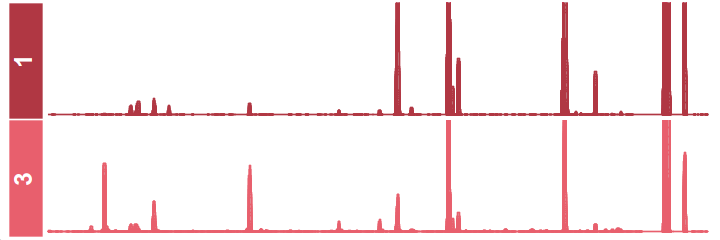

In [20]:
options(repr.plot.width = 6, repr.plot.height = 2)
as.ggplot(~plotTracks(bw_tracks, from=68720914, to=68851918))

In [21]:
gene_track = GeneRegionTrack(gene_anno, genome = "hg38", 
                                 chromosome = "chr16", 
                                 name = "", 
                                 collapseTranscripts="longest",
                                 transcriptAnnotation="symbol",
                                background.title = 'transparent')

gene_track2 = GeneRegionTrack(gene_anno, genome = "hg38", 
                                 chromosome = "chr16", 
                                 name = "", 
                                 collapseTranscripts="longest",
                                 transcriptAnnotation="symbol",
                                background.title = 'transparent',
                             stackHeight=0.5, fill='#000000', min.height=20)

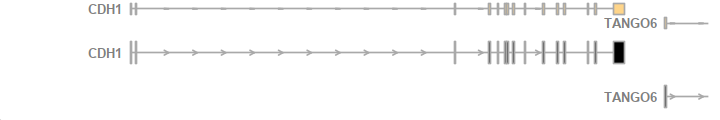

In [22]:
options(repr.plot.width = 6, repr.plot.height = 1)

as.ggplot(~plotTracks(c(gene_track, gene_track2), from=68720914, to=68851918, sizes=c(1,3)))

## Fig1 Panels

In [22]:
HIGHLIGHT_COL = "#f5f5f5"

In [23]:
bw_tracks = get_region_tracks("chr17", cluster_config, cluster_bigwigs, show_axis=T)
gene_track = get_gene_track("chr17", gene_anno, show_axis=T)
bw_highlighted = HighlightTrack(trackList = bw_tracks,
                               start=c(50186797, 50201208, 50203706), 
                               end=c(50188860, 50202306, 50204438), 
                               chromosome="chr17",
                               col=HIGHLIGHT_COL, fill=HIGHLIGHT_COL)

FROM = 50180384
TO = 50205975
COL1A1 = as.ggplot(~plotTracks(bw_highlighted,
                               from=FROM, to=TO,
                              sizes=rep(1,nrow(cluster_config))))+
       ggtitle("COL1A1") +
       theme(plot.title = element_text(hjust = 0.5, size=20),
            panel.border = element_rect(colour = "black", fill=NA, size=0.5))
COL1A1_gene = as.ggplot(~plotTracks(gene_track, from=FROM, to=TO)) 

In [24]:
bw_tracks = get_region_tracks("chr2", cluster_config, cluster_bigwigs, show_axis=F)
gene_track = get_gene_track("chr2", gene_anno, show_axis=F)
bw_highlighted = HighlightTrack(trackList = bw_tracks,
                               start=c(215432456, 215408255,215365609), 
                               end=c(215436269, 215414337,215370473), 
                               chromosome="chr2",
                               col=HIGHLIGHT_COL, fill=HIGHLIGHT_COL)

FROM = 215352785
TO = 215441884
FN1 = as.ggplot(~plotTracks(bw_highlighted,
                               from=FROM, to=TO,
                              sizes=rep(1,nrow(cluster_config))))+
       ggtitle("FN1") +
       theme(plot.title = element_text(hjust = 0.5, size=20),
            panel.border = element_rect(colour = "black", fill=NA, size=0.5))
FN1_gene = as.ggplot(~plotTracks(gene_track, from=FROM, to=TO)) 

In [25]:
bw_tracks = get_region_tracks("chr16", cluster_config, cluster_bigwigs, show_axis=F)
gene_track = get_gene_track("chr16", gene_anno, show_axis=F)
bw_highlighted = HighlightTrack(trackList = bw_tracks,
                               start=c(68731000, 68777300), 
                               end=c(68740000, 68780500), 
                               chromosome="chr16",
                               col=HIGHLIGHT_COL, fill=HIGHLIGHT_COL)

FROM = 68720914
TO = 68851918
CDH1 = as.ggplot(~plotTracks(c(bw_highlighted), 
                             from=FROM, to=TO, 
                             sizes=rep(1,nrow(cluster_config)))) +
       ggtitle("CDH1") +
       theme(plot.title = element_text(hjust = 0.5, size=20),
             panel.border = element_rect(colour = "black", fill=NA, size=0.5))
CDH1_gene = as.ggplot(~plotTracks(gene_track, from=FROM, to=TO)) 

In [26]:
bw_tracks = get_region_tracks("chr12", cluster_config, cluster_bigwigs, show_axis=F)
gene_track = get_gene_track("chr12", gene_anno, show_axis=F)
bw_highlighted = HighlightTrack(trackList = bw_tracks,
                               start=c(7787300), 
                               end=c(7789900), 
                               chromosome="chr12",
                               col=HIGHLIGHT_COL, fill=HIGHLIGHT_COL)

FROM = 7783273
TO = 7805263
NANOG = as.ggplot(~plotTracks(bw_highlighted, from=FROM, to=TO,
                             sizes=rep(1,nrow(cluster_config))))+
       ggtitle("NANOG") +
       theme(plot.title = element_text(hjust = 0.5, size=20),
            panel.border = element_rect(colour = "black", fill=NA, size=0.5))
NANOG_gene = as.ggplot(~plotTracks(gene_track, from=FROM, to=TO)) 

In [27]:
bw_tracks = get_region_tracks("chr6", cluster_config, cluster_bigwigs, show_axis=F)
gene_track = get_gene_track("chr6", gene_anno, show_axis=F)
bw_highlighted = HighlightTrack(trackList = bw_tracks,
                               start=c(31170331), 
                               end=c(31173736), 
                               chromosome="chr6",
                               col=HIGHLIGHT_COL, fill=HIGHLIGHT_COL)

FROM = 31160139
TO = 31184929
POU5F1 = as.ggplot(~plotTracks(bw_highlighted, 
                               from=FROM, to=TO,
                              sizes=rep(1,nrow(cluster_config))))+
       ggtitle("OCT4") +
       theme(plot.title = element_text(hjust = 0.5, size=20),
            panel.border = element_rect(colour = "black", fill=NA, size=0.5))
POU5F1_gene = as.ggplot(~plotTracks(gene_track, from=FROM, to=TO)) 

In [41]:
COL1A1_expr = get_expression_plot(as.vector(rna[['RNA']]["COL1A1"]), factor(atac.rna.label$atac_new_cluster))
FN1_expr = get_expression_plot(as.vector(rna[['RNA']]["FN1"]), factor(atac.rna.label$atac_new_cluster))
CDH1_expr = get_expression_plot(as.vector(rna[['RNA']]["CDH1"]), factor(atac.rna.label$atac_new_cluster))
NANOG_expr = get_expression_plot(as.vector(rna[['RNA']]["NANOG"]), factor(atac.rna.label$atac_new_cluster))
POU5F1_expr = get_expression_plot(as.vector(rna[['RNA']]["POU5F1"]), factor(atac.rna.label$atac_new_cluster))

In [36]:
cluster_label_df = cluster_config

# BOTTOM_PT = nrow(cluster_label_df)+0

# cluster_label_df[nrow(cluster_label_df)+1, ] = c(nrow(cluster_label_df)+1, "", "", 1)
# cluster_label_df[nrow(cluster_label_df)+1, ] = c(nrow(cluster_label_df)+1, "", "", BOTTOM_PT)

# need to play around with these parameters to find the right fit
cluster_labels_plot <- ggplot(cluster_label_df) +
    geom_text(aes(x=0, y= -as.numeric(new_cluster), label=description, hjust=1, vjust=0.5)) +
    theme_void() +
    theme(plot.margin = unit(c(0,-95,0,0), "pt"))
# wrap
cluster_labels_plot = wrap_plots(plot_spacer(), cluster_labels_plot, plot_spacer(), widths=c(0,1,0))


# add to debug- shows how ggplot dots align with genome track labels
# for (i in seq(1,18)) {
#     cluster_labels_plot = cluster_labels_plot + geom_point(x=0, y= -i)
# }

# cluster_labels_plot = cluster_labels_plot + geom_point(x=0, y= -BOTTOM_PT, colour='red')

In [42]:
top_plots = wrap_plots(cluster_labels_plot,
                    COL1A1,
                    COL1A1_expr,
                    plot_spacer(),                    
                    FN1,
                    FN1_expr,
                    plot_spacer(),
                    CDH1,
                    CDH1_expr,
                    plot_spacer(),
                    NANOG,
                    NANOG_expr,
                    widths=c(2,5,1,0,5,1,0,5,1,0,5,1))

bottom_plots = wrap_plots(
    plot_spacer(),
    COL1A1_gene,
    plot_spacer(),
    FN1_gene,
    plot_spacer(),
    CDH1_gene,
    plot_spacer(),
    NANOG_gene,
    plot_spacer(),
    widths=c(2,5,1,5,1,5,1,5,1)
)

myplot = wrap_plots(top_plots, bottom_plots, heights=c(11,1))

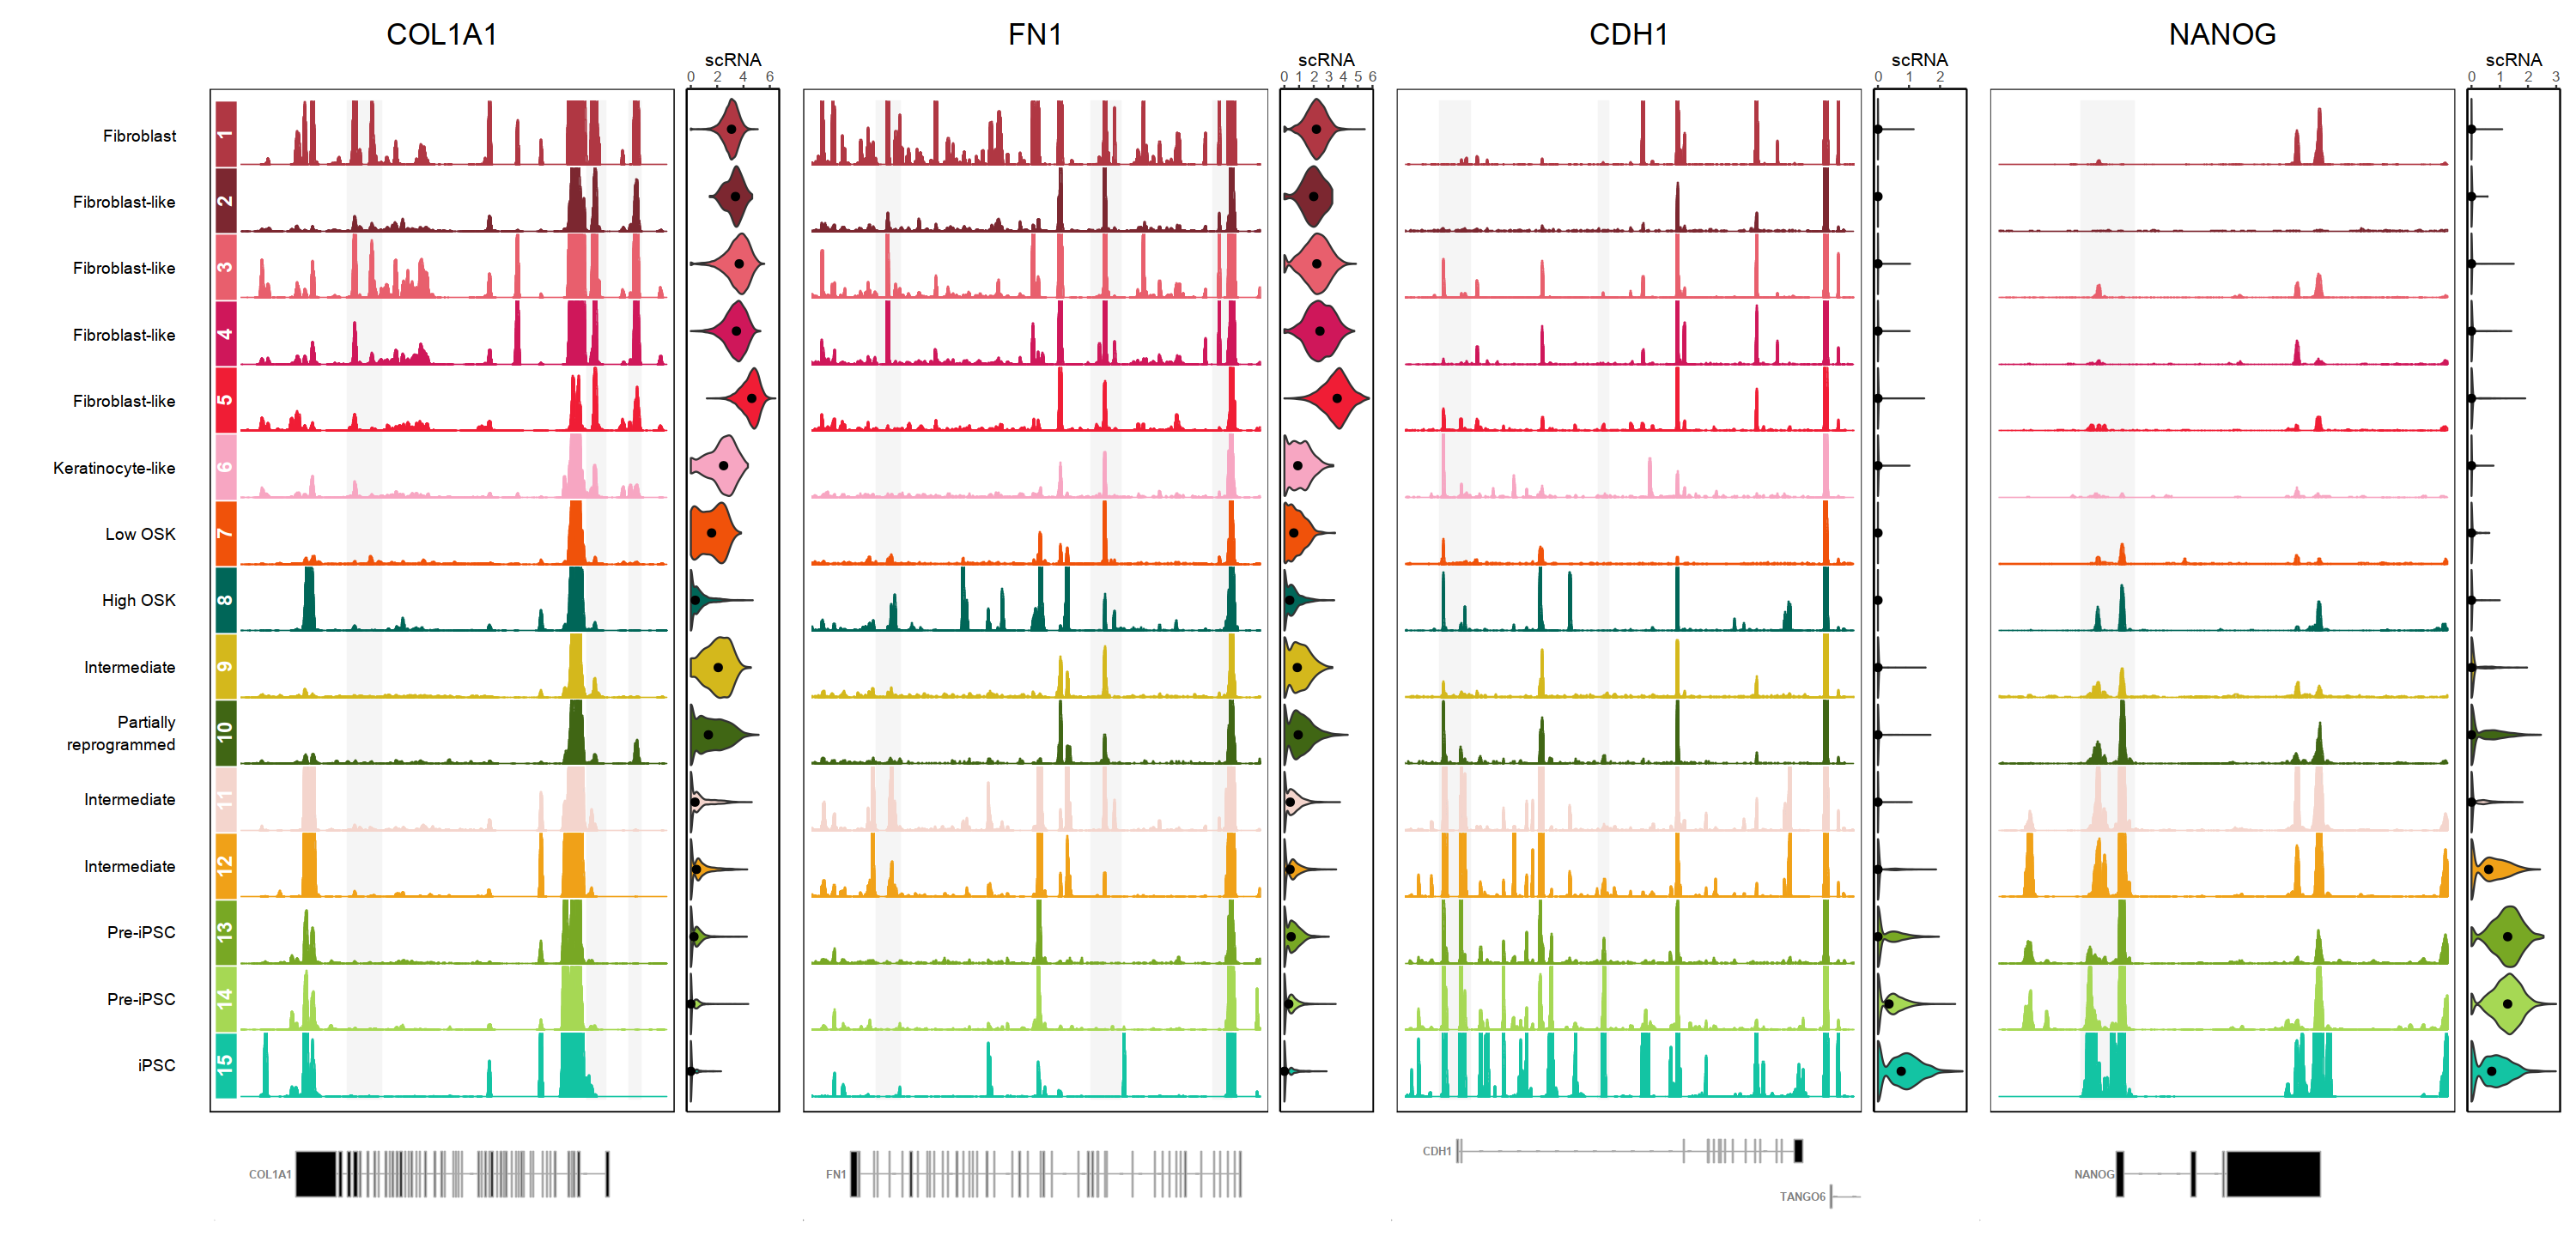

In [43]:
options(repr.plot.width = 25, repr.plot.height = 12)

myplot

In [44]:
saveRDS(COL1A1, file=sprintf("./Fig1/subfigs/%s_COL1A1_atac.rds",
                                   format(Sys.Date(), "%Y%m%d")))
saveRDS(FN1, file=sprintf("./Fig1/subfigs/%s_FN1_atac.rds",
                                   format(Sys.Date(), "%Y%m%d")))
saveRDS(CDH1, file=sprintf("./Fig1/subfigs/%s_CDH1_atac.rds",
                                   format(Sys.Date(), "%Y%m%d")))
saveRDS(NANOG, file=sprintf("./Fig1/subfigs/%s_NANOG_atac.rds",
                                   format(Sys.Date(), "%Y%m%d")))
saveRDS(cluster_labels_plot, file=sprintf("./Fig1/subfigs/%s_browser_labels.rds",
                                   format(Sys.Date(), "%Y%m%d")))

saveRDS(COL1A1_gene, file=sprintf("./Fig1/subfigs/%s_COL1A1_atac_gene.rds",
                                   format(Sys.Date(), "%Y%m%d")))
saveRDS(FN1_gene, file=sprintf("./Fig1/subfigs/%s_FN1_atac_gene.rds",
                                   format(Sys.Date(), "%Y%m%d")))
saveRDS(CDH1_gene, file=sprintf("./Fig1/subfigs/%s_CDH1_atac_gene.rds",
                                   format(Sys.Date(), "%Y%m%d")))
saveRDS(NANOG_gene, file=sprintf("./Fig1/subfigs/%s_NANOG_atac_gene.rds",
                                   format(Sys.Date(), "%Y%m%d")))

saveRDS(COL1A1_expr, file=sprintf("./Fig1/subfigs/%s_COL1A1_expr.rds",
                                   format(Sys.Date(), "%Y%m%d")))
saveRDS(FN1_expr, file=sprintf("./Fig1/subfigs/%s_FN1_expr.rds",
                                   format(Sys.Date(), "%Y%m%d")))
saveRDS(CDH1_expr, file=sprintf("./Fig1/subfigs/%s_CDH1_expr.rds",
                                   format(Sys.Date(), "%Y%m%d")))
saveRDS(NANOG_expr, file=sprintf("./Fig1/subfigs/%s_NANOG_expr.rds",
                                   format(Sys.Date(), "%Y%m%d")))

In [220]:
ggsave("tmp.pdf", myplot, height=12, width=25)

In [30]:
# options(repr.plot.width = 10, repr.plot.height = 12)

# ZEB1_expr = get_expression_plot(as.vector(rna[['RNA']]["ZEB1"]), factor(atac.rna.label$atac_new_cluster))
# ZEB2_expr = get_expression_plot(as.vector(rna[['RNA']]["ZEB2"]), factor(atac.rna.label$atac_new_cluster))
# SNAI1_expr = get_expression_plot(as.vector(rna[['RNA']]["SNAI1"]), factor(atac.rna.label$atac_new_cluster))
# SNAI2_expr = get_expression_plot(as.vector(rna[['RNA']]["SNAI2"]), factor(atac.rna.label$atac_new_cluster))
# wrap_plots(cluster_labels_plot, ZEB1_expr, ZEB2_expr, SNAI1_expr, SNAI2_expr,widths=c(1,1,1, 1,1))

## Fig2 Panels

In [66]:
bw_tracks = get_region_tracks("chr2", cluster_config, cluster_bigwigs, show_axis=T)
gene_track = get_gene_track("chr2", gene_anno, show_axis=T)
bw_highlighted = HighlightTrack(trackList = bw_tracks,
                               start=c(), #c(209566734), 
                               end=c(), #c(209626252), 
                               chromosome="chr2",
                               col=HIGHLIGHT_COL, fill=HIGHLIGHT_COL)

FROM = 209382919
TO = 209482919 # 209743439
MAP2 = as.ggplot(~plotTracks(c(bw_highlighted), 
                               from=FROM, to= TO,
                              sizes=rep(1,nrow(cluster_config))))+
       ggtitle("MAP2") +
       theme(plot.title = element_text(hjust = 0.5, size=20),
            panel.border = element_rect(colour = "black", fill=NA, size=0.5))

MAP2_gene = as.ggplot(~plotTracks(gene_track, from=FROM, to=TO)) 

In [80]:
bw_tracks = get_region_tracks("chr5", cluster_config, cluster_bigwigs, show_axis=F)
gene_track = get_gene_track("chr5", gene_anno, show_axis=F)
bw_highlighted = HighlightTrack(trackList = bw_tracks,
                               start=c(147646055, 147767684, 147778363), 
                               end=c(147649831, 147771200, 147785395), 
                               chromosome="chr5",
                               col=HIGHLIGHT_COL, fill=HIGHLIGHT_COL)


JAKMIP2 = as.ggplot(~plotTracks(c(bw_highlighted, gene_track), 
                               from=147554719, to=147813263,
                              sizes=rep(1,nrow(cluster_config)+1)))+
       ggtitle("JAKMIP2") +
       theme(plot.title = element_text(hjust = 0.5, size=20),
            panel.border = element_rect(colour = "black", fill=NA, size=0.5))

In [81]:
bw_tracks = get_region_tracks("chr17", cluster_config, cluster_bigwigs, show_axis=F)
gene_track = get_gene_track("chr17", gene_anno, show_axis=F)
bw_highlighted = HighlightTrack(trackList = bw_tracks,
                               start=c(41612394), 
                               end=c(41613305), 
                               chromosome="chr17",
                               col=HIGHLIGHT_COL, fill=HIGHLIGHT_COL)


KRT16 = as.ggplot(~plotTracks(c(bw_highlighted, gene_track), 
                               from=41606899, to=41614485,
                              sizes=rep(1,nrow(cluster_config)+1)))+
       ggtitle("KRT16") +
       theme(plot.title = element_text(hjust = 0.5, size=20),
            panel.border = element_rect(colour = "black", fill=NA, size=0.5))

In [82]:
bw_tracks = get_region_tracks("chr19", cluster_config, cluster_bigwigs, show_axis=F)
gene_track = get_gene_track("chr19", gene_anno, show_axis=F)
bw_highlighted = HighlightTrack(trackList = bw_tracks,
                               start=c(51026182), 
                               end=c(51027891), 
                               chromosome="chr19",
                               col=HIGHLIGHT_COL, fill=HIGHLIGHT_COL)


KLK11 = as.ggplot(~plotTracks(c(bw_highlighted, gene_track), 
                               from=51020832, to=51028608,
                              sizes=rep(1,nrow(cluster_config)+1)))+
       ggtitle("KLK11") +
       theme(plot.title = element_text(hjust = 0.5, size=20),
            panel.border = element_rect(colour = "black", fill=NA, size=0.5))

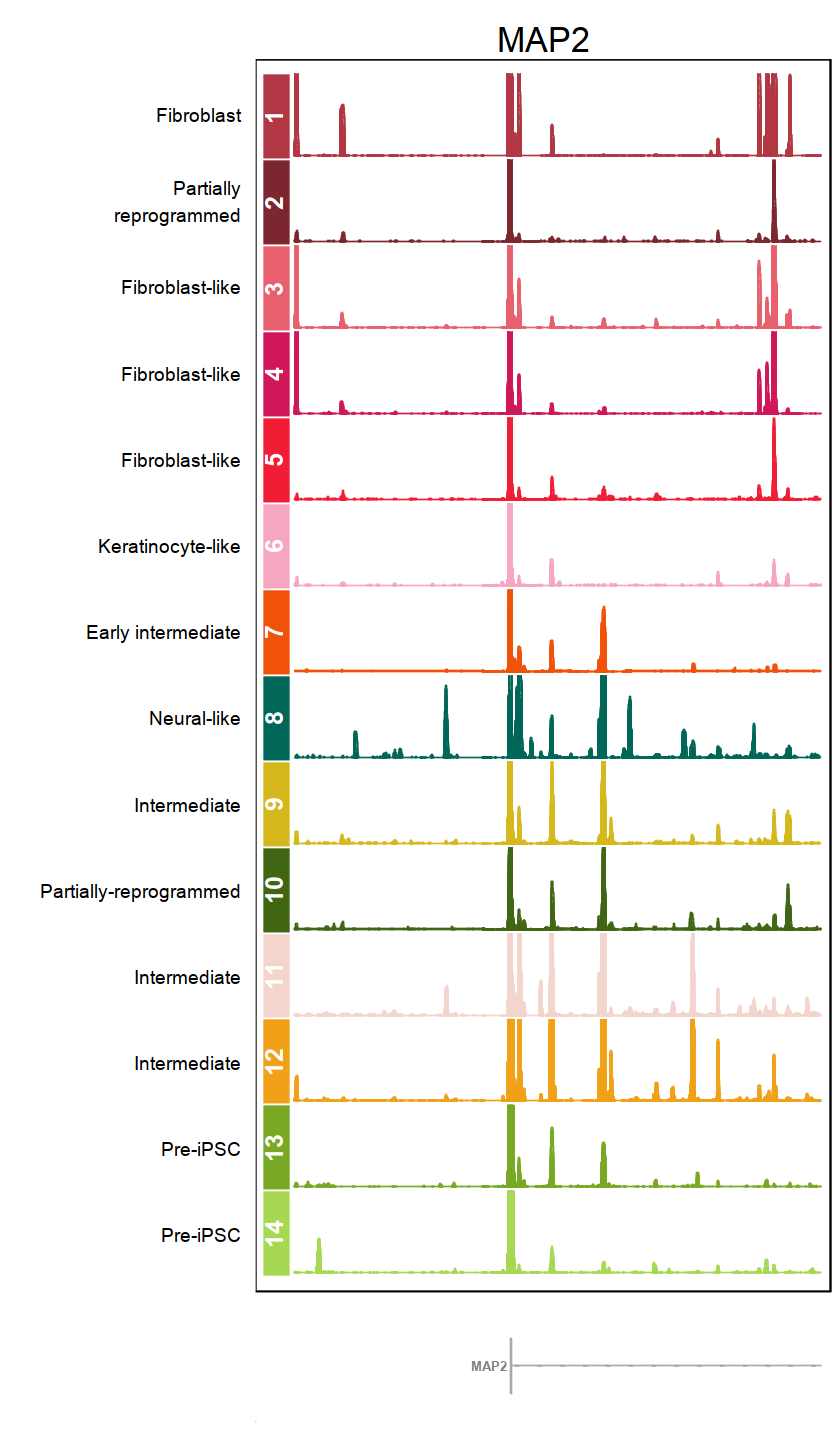

In [67]:
options(repr.plot.width = 7, repr.plot.height = 12)

wrap_plots(wrap_plots(cluster_labels_plot,
           plot_spacer(),
           plot_spacer(),
                    MAP2,
                   widths=c(3,-1.0001, 0, 6)),
           wrap_plots(plot_spacer(), 
                      plot_spacer(),
                      plot_spacer(),
                      MAP2_gene,
                     widths=c(3,-1.0001, 0, 6)),
           heights=c(11,1))
           

In [83]:
myplot = wrap_plots(cluster_labels_plot,
                    MAP2,
                    plot_spacer(),
                    JAKMIP2,
                    plot_spacer(),
                    KRT16,
                    plot_spacer(),
                    KLK11, widths=c(3,6,0,6,1,6,0,6))

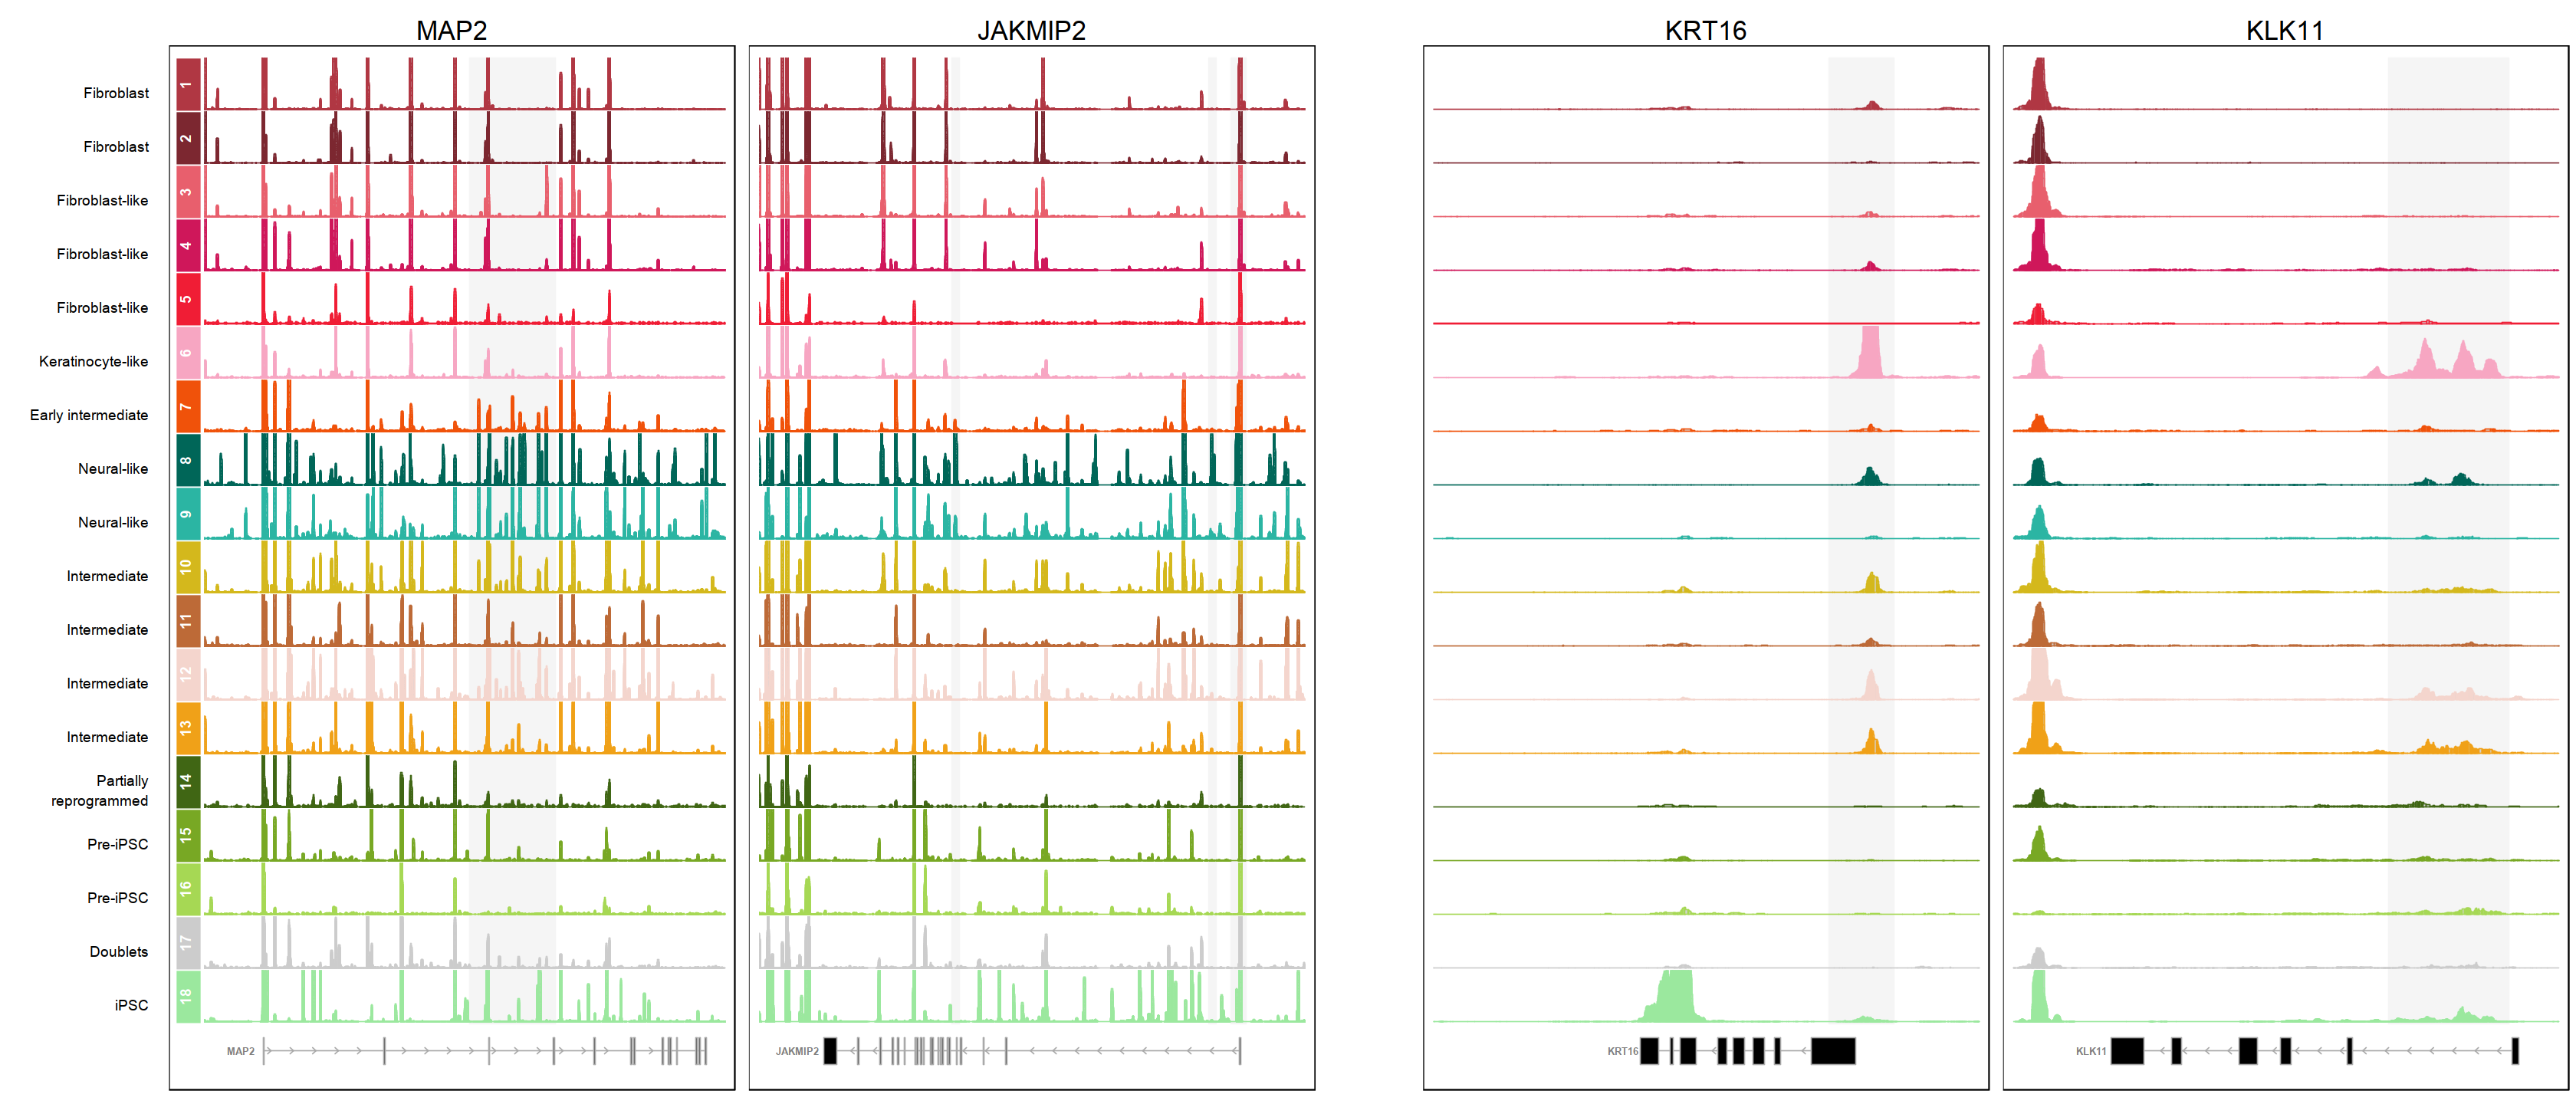

In [84]:
options(repr.plot.width = 28, repr.plot.height = 12)

myplot

In [85]:
saveRDS(MAP2, file=sprintf("./Fig2/subfigs/%s_MAP2.rds",
                                   format(Sys.Date(), "%Y%m%d")))
saveRDS(JAKMIP2, file=sprintf("./Fig2/subfigs/%s_JAKMIP2.rds",
                                   format(Sys.Date(), "%Y%m%d")))
saveRDS(KRT16, file=sprintf("./Fig2/subfigs/%s_KRT16.rds",
                                   format(Sys.Date(), "%Y%m%d")))
saveRDS(KLK11, file=sprintf("./Fig2/subfigs/%s_KLK11.rds",
                                   format(Sys.Date(), "%Y%m%d")))
# saveRDS(cluster_labels_plot, file=sprintf("./Fig2/subfigs/%s_browser_labels.rds",
#                                    format(Sys.Date(), "%Y%m%d")))

In [111]:
ggsave("tmp.png", myplot, height=12, width=15)

## Fig3 Panels

In [143]:
bw_tracks = get_region_tracks("chr20", cluster_config, cluster_bigwigs, show_axis=T)

gene_track = get_gene_track("chr20", gene_anno, show_axis=T)
bw_highlighted = HighlightTrack(trackList = bw_tracks,
                               start=c(51775218, 51807938, 51811026, 51793768, 51802180,51799803), 
                               end=c(51776101, 51808171, 51811234, 51794010, 51802882, 51801841), 
                               chromosome="chr20",
                               col=HIGHLIGHT_COL, fill=HIGHLIGHT_COL)


SALL4 = as.ggplot(~plotTracks(c(bw_highlighted, gene_track), 
                               from=51774290, to=51814020,
                               title.width=0.6,
                              sizes=rep(1,nrow(cluster_config)+1)))+
#        ggtitle("KLK11") +
       theme(plot.title = element_text(hjust = 0.5, size=20),
            panel.border = element_rect(colour = "black", fill=NA, size=0.5))

In [144]:
myplot = wrap_plots(cluster_labels_plot,
                    SALL4, widths=c(2.7,12.3))

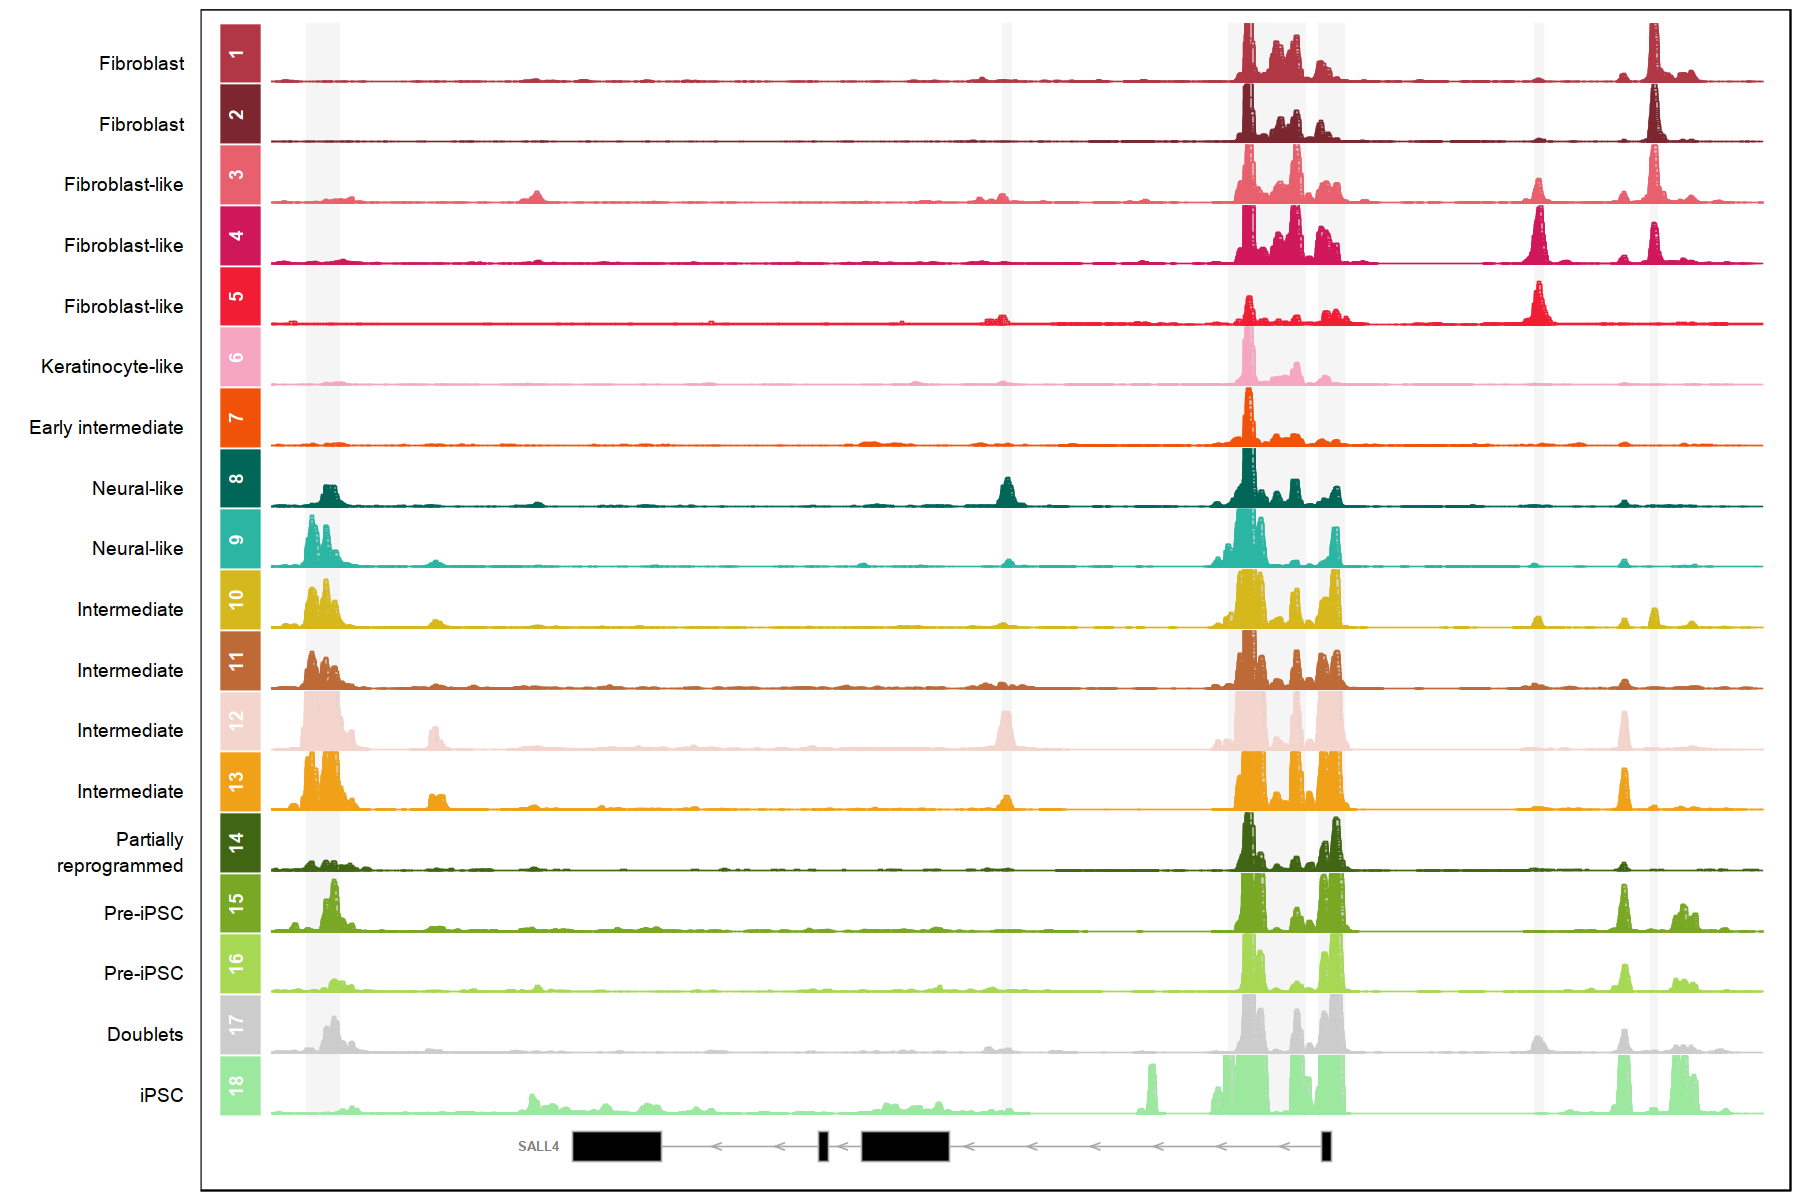

In [145]:
options(repr.plot.width = 15, repr.plot.height = 10)
myplot

In [148]:
saveRDS(SALL4, file=sprintf("./Fig3/subfigs/%s_locus.rds",
                                format(Sys.Date(), "%Y%m%d")))